## Movie Recommendation System 
In this notebook, we create a recommendation system for movies, based on user ratings. 

### Data
To build the system, we use [MovieLens](https://movielens.org/) dataset of 100k ratings from [https://grouplens.org/datasets/movielens/](https://grouplens.org/datasets/movielens/). Specifically, we use three csv file from this dataset:
* u.user: user information file. Features: 'user_id', 'age', 'sex', 'occupation', 'zip_code'
* u.item: movie information file. Features: 'movie_id','movie_title','release_date','video_release_date','IMDb URL',list of genre
* u.data: rating information file. Features: user_id', 'movie_id', 'rating', 'unix_timestamp'

### Methodology
We build two candidate generator models in this notebook: Matrix Factorization and Softmax model. This notebook is built based on a Google Colab notebook found [here](https://colab.research.google.com/drive/1WN1OGnwFmcbxnmM-bNiEm87tv0umEjIc#scrollTo=G_Kko-YxF6YE). 
#### Matirx Factorization:  
Unlike the Colab notebook, here we use a scikit learn SVD model to do matrix factorization. When an opensource implemetation of an algorithm exists, it is better to use that instead of creating the algorithm ourselves. 

#### Softmax Model:

#### Reading Data
In this section, we simply read three csv files: u.user, u.item and u.data. The first two files are | separated and u.data is tab separated. We will use user_id and movie_id fields as indecies into users and movies tables. Since these strat from 1 instead of zero, we change them to start from 0 by reduding each id by 1.

In [23]:
import pandas as pd
import numpy as np
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    '01_data/u.user', sep='|', names=users_cols, encoding='latin-1')

movie_cols = ['movie_id','movie_title','release_date','video_release_date',
             'IMDb URL','unknown','Action','Adventure','Animation',
             'Children\'s','Comedy','Crime','Documentary','Drama','Fantasy',
             'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi',
             'Thriller','War','Western']
movies = pd.read_csv(
    '01_data/u.item', sep='|', names=movie_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    '01_data/u.data', sep='\t', names=ratings_cols, encoding='latin-1')


users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

print(users.shape,movies.shape,ratings.shape)

(943, 5) (1682, 25) (100000, 4)


In [24]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995


#### Sparse Matrix
We use scipy sparse matrix library to create a sparse matrix of user-ratings. The sparse matrix is defined by its shape and its non-zero elements. Here, we have 943 users and 1682 items. So, our feedback matrix is a 943 * 1682 matrix. To specify a non-zero element, we need its position (row,col) and its value (data). To create the sparse matrix, we create 3 arrays: array of row indecies, array of column indecies and array of values. These 3 arrays together with the shape information can be passed to csr_matrix function to create a scipy sparse matrix, as follows.

In [25]:
from scipy.sparse import csr_matrix

row_inds = ratings['user_id'].values
col_inds = ratings['movie_id'].values
data = ratings['rating'].values

#csr if not explicitly define shape, it gives weird errors..
A = csr_matrix((data,(row_inds,col_inds)),shape=(943,1682))
print(A.toarray())

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


#### Matrix Factorization via SVD
Simply import TruncatedSVD, indicate the number of componenets you need to have in the output (d) and fit the model on the feedback matrix. That's it.

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
svd.fit(A)

TruncatedSVD(n_components=30, n_iter=7, random_state=42)

#### User Matrix
A = U * D * V^T where U * U^T = I and V * V^T = I.  
So, A * V = U * D * V^T * V = U * D, which we consider as U.  
Note that svd.transform(X) = X * V

In [27]:
U = svd.transform(A)
print(U.shape)

(943, 30)


In [28]:
len(A.toarray()[1])

1682

In [29]:
len(U[1])

30

#### Item Matrix
V = I * V

In [30]:
id_rows = [i for i in range(1682)]
id_cols = [i for i in range(1682)]
id_data = [1 for i in range(1682)]
I = csr_matrix((id_data,(id_rows,id_cols)),shape=(1682,1682))
print(I.toarray())

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


In [31]:
V = svd.transform(I)
print(V.shape)

(1682, 30)


#### Similarity Calculator Function
Strait from the Colab notebook

In [32]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure=DOT):
    """Computes the scores of the candidates given a query.
    Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
    Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
    """
    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

#### Recommendation Calculator

In [33]:
def get_recomms(u_emb,m_embs,movies=movies,measure=COSINE,k=5):
    scores = compute_scores(u_emb,m_embs,measure=measure)
    u_movies = movies.copy()
    u_movies['score'] = [round(x,4) for x in scores]
    return u_movies.sort_values(['score'], 
            ascending=False)[['movie_id','movie_title','score']].iloc[:k,:]

In [34]:
get_recomms(U[150],V)

,movie_id,movie_title,score
477,477,"Philadelphia Story, The (1940)",0.4871
605,605,All About Eve (1950),0.4730
601,601,"American in Paris, An (1951)",0.4684
498,498,Cat on a Hot Tin Roof (1958),0.4379
487,487,Sunset Blvd. (1950),0.4334


In [35]:
get_recomms(U[562],V)

,movie_id,movie_title,score
180,180,Return of the Jedi (1983),0.6600
49,49,Star Wars (1977),0.6482
254,254,My Best Friend's Wedding (1997),0.6148
65,65,While You Were Sleeping (1995),0.5246
1471,1471,"Visitors, The (Visiteurs, Les) (1993)",0.4823


In [36]:
get_recomms(U[151],V)

,movie_id,movie_title,score
154,154,Dirty Dancing (1987),0.6004
691,691,"American President, The (1995)",0.5991
65,65,While You Were Sleeping (1995),0.5856
738,738,Pretty Woman (1990),0.5575
110,110,"Truth About Cats & Dogs, The (1996)",0.5450


#### Softmax Model
The softmax model gets as input a vector of ratings of a user and outputs the probability of a user rating a movie.

To get the movies that a user rated, we groupby the rating table by user_id.

In [37]:
rated_movies = ratings[["user_id", "movie_id"]] \
                .groupby("user_id", as_index=False) \
                .aggregate(lambda x: list(x))
rated_movies.head()

,user_id,movie_id
0,0,"[60, 188, 32, 159, 19, 201, 170, 264, 154, 116..."
1,1,"[291, 250, 49, 313, 296, 289, 311, 280, 12, 27..."
2,10,"[110, 557, 731, 226, 424, 739, 722, 37, 724, 1..."
3,100,"[828, 303, 595, 221, 470, 404, 280, 251, 281, ..."
4,101,"[767, 822, 69, 514, 523, 321, 624, 160, 447, 4..."


#### Combining Genre

In [38]:
genre_cols = [
    "unknown", "Action", "Adventure", "Animation", "Children\'s", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]

def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
        get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
        get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies.drop(genre_cols,axis=1,inplace=True)

mark_genres(movies, genre_cols)

In [39]:
#movies.drop(['genre', 'all_genres'], axis = 1)

In [18]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,IMDb URL,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Comedy,Animation-Children's-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995,Thriller,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,1995,Drama,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),1995,Crime,Crime-Drama-Thriller


#### Creating Movies Example Batch
each example contains the following features:

* movie_id: A tensor of strings of the movie ids that the user rated.
* genre: A tensor of strings of the genres of those movies
* year: A tensor of strings of the release year.


In [40]:
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}
genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

In [35]:
def make_batch(ratings, batch_size):
    """Creates a batch of examples.
        Args:
        ratings: A DataFrame of ratings such that examples["movie_id"] is a list of
            movies rated by a user.
        batch_size: The batch size.
    """
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values

    movie = []
    year = []
    genre = []
    label = []
    for movie_ids in ratings["movie_id"].values:
        movie.append(movie_ids)
        genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
        year.append([years_dict[movie_id] for movie_id in movie_ids])
        label.append([int(movie_id) for movie_id in movie_ids])
    features = {
        "movie_id": pad(movie, ""),
        "year": pad(year, ""),
        "genre": pad(genre, ""),
        "label": pad(label, -1)
    }
    batch = (
        tf.data.Dataset.from_tensor_slices(features)
        .shuffle(1000)
        .repeat()
        .batch(batch_size)
        .make_one_shot_iterator()
        .get_next())
    return batch

def select_random(x):
    """Selectes a random elements from each row of x."""
    def to_float(x):
        return tf.cast(x, tf.float32)
    def to_int(x):
        return tf.cast(x, tf.int64)
    batch_size = tf.shape(x)[0]
    rn = tf.range(batch_size)
    nnz = to_float(tf.count_nonzero(x >= 0, axis=1))
    rnd = tf.random_uniform([batch_size])
    ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
    return to_int(tf.gather_nd(x, ids))

#### Cross-Entropy Loss Function

In [36]:
def softmax_loss(user_embeddings, movie_embeddings, labels):
    """Returns the cross-entropy loss of the softmax model.
    Args:
        user_embeddings: A tensor of shape [batch_size, embedding_dim].
        movie_embeddings: A tensor of shape [num_movies, embedding_dim].
        labels: A tensor of [batch_size], such that labels[i] is the target label
            for example i.
    Returns:
        The mean cross-entropy loss.
    """
    # Verify that the embddings have compatible dimensions
    user_emb_dim = user_embeddings.shape[1].value
    movie_emb_dim = movie_embeddings.shape[1].value
    if user_emb_dim != movie_emb_dim:
        raise ValueError(
            "The user embedding dimension %d should match the movie embedding "
            "dimension % d" % (user_emb_dim, movie_emb_dim))

    logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))
    return loss

#### Creating Softmax Model

In [37]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    """Splits a DataFrame into training and test sets.
    Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
    Returns:
    train: dataframe for training
    test: dataframe for testing
    """
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [39]:
import collections
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

class CFModel(object):
    """Simple class that represents a collaborative filtering model"""
    def __init__(self, embedding_vars, loss, metrics=None):
        """Initializes a CFModel.
        Args:
          embedding_vars: A dictionary of tf.Variables.
          loss: A float Tensor. The loss to optimize.
          metrics: optional list of dictionaries of Tensors. The metrics in each
            dictionary will be plotted in a separate figure during training.
        """
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        """The embeddings dictionary."""
        return self._embeddings
    
    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        """Trains the model.
        Args:
          iterations: number of iterations to run.
          learning_rate: optimizer learning rate.
          plot_results: whether to plot the results at the end of training.
          optimizer: the optimizer to use. Default to GradientDescentOptimizer.
        Returns:
          The metrics dictionary evaluated at the last iteration.
        """
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                            ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                            end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)
            for k, v in self._embedding_vars.items():
                    self._embeddings[k] = v.eval()

        if plot_results:
            # Plot the metrics.
            num_subplots = len(metrics)+1
            fig = plt.figure()
            fig.set_size_inches(num_subplots*10, 8)
            for i, metric_vals in enumerate(metrics_vals):
                ax = fig.add_subplot(1, num_subplots, i+1)
                for k, v in metric_vals.items():
                    ax.plot(iterations, v, label=k)
                ax.set_xlim([1, num_iterations])
                ax.legend()
        return results

In [40]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
    """Builds a Softmax model for MovieLens.
        Args:
            rated_movies: DataFrame of traing examples.
            embedding_cols: A dictionary mapping feature names (string) to embedding
            column objects. This will be used in tf.feature_column.input_layer() to
            create the input layer.
        hidden_dims: int list of the dimensions of the hidden layers.
        Returns:
            A CFModel object.
    """
    def create_network(features):
        """Maps input features dictionary to user embeddings.
        Args:
          features: A dictionary of input string tensors.
        Returns:
          outputs: A tensor of shape [batch_size, embedding_dim].
        """
        # Create a bag-of-words embedding for each sparse feature.
        inputs = tf.feature_column.input_layer(features, embedding_cols)
        # Hidden layers.
        input_dim = inputs.shape[1].value
        for i, output_dim in enumerate(hidden_dims):
            w = tf.get_variable(
                "hidden%d_w_" % i, shape=[input_dim, output_dim],
                initializer=tf.truncated_normal_initializer(
                    stddev=1./np.sqrt(output_dim))) / 10.
        outputs = tf.matmul(inputs, w)
        input_dim = output_dim
        inputs = outputs
        return outputs

    train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
    train_batch = make_batch(train_rated_movies, 200)
    test_batch = make_batch(test_rated_movies, 100)

    with tf.variable_scope("model", reuse=False):
        # Train
        train_user_embeddings = create_network(train_batch)
        train_labels = select_random(train_batch["label"])
    with tf.variable_scope("model", reuse=True):
        # Test
        test_user_embeddings = create_network(test_batch)
        test_labels = select_random(test_batch["label"])
        movie_embeddings = tf.get_variable(
            "input_layer/movie_id_embedding/embedding_weights")

    test_loss = softmax_loss(
        test_user_embeddings, movie_embeddings, test_labels)
    train_loss = softmax_loss(
        train_user_embeddings, movie_embeddings, train_labels)
    _, test_precision_at_10 = tf.metrics.precision_at_k(
        labels=test_labels,
        predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
        k=10)

    metrics = (
        {"train_loss": train_loss, "test_loss": test_loss},
        {"test_precision_at_10": test_precision_at_10}
    )
    embeddings = {"movie_id": movie_embeddings}
    return CFModel(embeddings, train_loss, metrics)

#### Train Softmax Model

 iteration 3000: train_loss=5.618753, test_loss=5.563675, test_precision_at_10=0.012412

({'train_loss': 5.6187534, 'test_loss': 5.563675},
 {'test_precision_at_10': 0.012411529490169944})

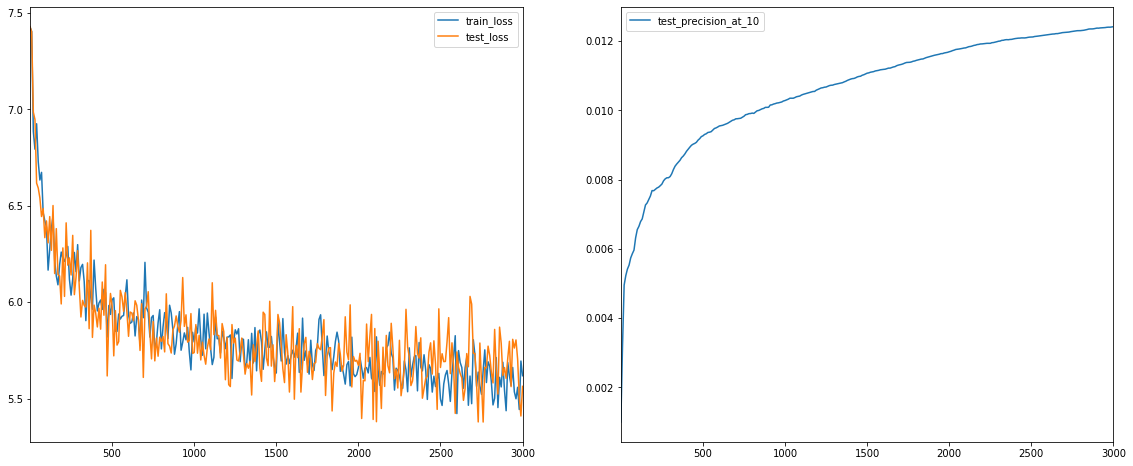

In [41]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
    categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
    return tf.feature_column.embedding_column(
        categorical_column=categorical_col, dimension=embedding_dim,
        # default initializer: trancated normal with stddev=1/sqrt(dimension)
        combiner='mean')

with tf.Graph().as_default():
    softmax_model = build_softmax_model(
        rated_movies,
        embedding_cols=[
            make_embedding_col("movie_id", 35),
            make_embedding_col("genre", 3),
            make_embedding_col("year", 2),
        ],
        hidden_dims=[35])


softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

#### Movie Suggestions

In [46]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
    # Search for movie ids that match the given substring.
    ids =  movies[movies['movie_title'].str.contains(title_substring)].index.values
    titles = movies.iloc[ids]['movie_title'].values
    if len(titles) == 0:
        raise ValueError("Found no movies with title %s" % title_substring)
    print("Nearest neighbors of : %s." % titles[0])
    if len(titles) > 1:
        print("[Found more than one matching movie. Other candidates: {}]".format(
            ", ".join(titles[1:])))
    movie_id = ids[0]
    scores = compute_scores(
        model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
        measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'titles': movies['movie_title'],
        'genres': movies['all_genres']
    })
    return df.sort_values([score_key], ascending=False).iloc[:k,:]

In [44]:
movie_neighbors(softmax_model, "Aladdin", DOT).head()

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,dot score,titles,genres
49,22.417894,Star Wars (1977),Action-Adventure-Romance-Sci-Fi-War
221,22.415382,Star Trek: First Contact (1996),Action-Adventure-Sci-Fi
94,22.004852,Aladdin (1992),Animation-Children's-Comedy-Musical
97,20.659477,"Silence of the Lambs, The (1991)",Drama-Thriller
173,20.658285,Raiders of the Lost Ark (1981),Action-Adventure


In [45]:
movie_neighbors(softmax_model, "Aladdin", COSINE).head()

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


,cosine score,titles,genres
94,1.000000,Aladdin (1992),Animation-Children's-Comedy-Musical
70,0.909960,"Lion King, The (1994)",Animation-Children's-Musical
587,0.886862,Beauty and the Beast (1991),Animation-Children's-Musical
418,0.856806,Mary Poppins (1964),Children's-Comedy-Musical
81,0.834720,Jurassic Park (1993),Action-Adventure-Sci-Fi
